In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import SGDRegressor, Ridge, LinearRegression
from sklearn.metrics import root_mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import PolynomialFeatures



# Datasets

In [3]:
#Pre-processes dataset and splits it into train and test-set in 8:2 ratio
def preprocessing(df, y_label):
    '''

    Parameters:
        df: pandas dataframe
        y_label: str
    Returns:
        Xtrain: np.ndarray
        Ytrain: np.ndarray
        Xtest: np.ndarray
        Ytest: np.ndarray

    '''

    #Get all columns with exactly two unique non-numeric values
    cols_with_two_unique_values = [col for col in df.columns if df[col].nunique(dropna=False) == 2 and not pd.api.types.is_numeric_dtype(df[col])]

    #replacing unique values with 0s and 1s in such columns (this can reduce unnecessary columns after one-hot encoding classification datasets)
    for col in cols_with_two_unique_values:
        values = df[col].unique()
        df[col] = df[col].replace({values[0]: 0, values[1]: 1})

    #One-hot encoding remaining non-numeric columns and replace boolean values with binary values
    df = pd.get_dummies(df).replace({False: 0, True: 1})

    #Drop rows with missing values (if any)
    df = df.dropna()

    #Normalize data
    df = (df - df.min()) / (df.max() - df.min())


    #split into train and test set
    df_train = df.sample(frac=0.8, axis=0)
    df_test = df.drop(df_train.index)

    #Choose target feature
    y_train = df_train[f'{y_label}'].to_numpy()
    X_train = df_train.drop(columns=[f'{y_label}']).to_numpy()

    y_test = df_test[f'{y_label}'].to_numpy()
    X_test = df_test.drop(columns=[f'{y_label}']).to_numpy()

    return X_train, y_train, X_test, y_test

In [4]:
#Dataset D1
X_d1 = np.random.normal(1, 0.05, 100)
psi = np.random.randn(100)
y_d1 = 1.3 * np.power(X_d1, 2) + 4.8 * X_d1 + 8 + psi
#Since sklearn expects 2d array
X_d1 = X_d1.reshape(-1, 1)


#Wine-quality dataset D2
df_wine = pd.read_csv('winequality-red.csv', sep=';')
#Preprocess data
Xtrain_d2, ytrain_d2, Xtest_d2, ytest_d2 = preprocessing(df_wine, y_label='quality')



# Generalized Linear Models

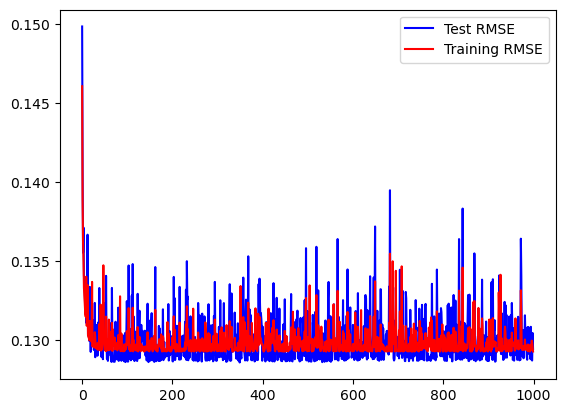

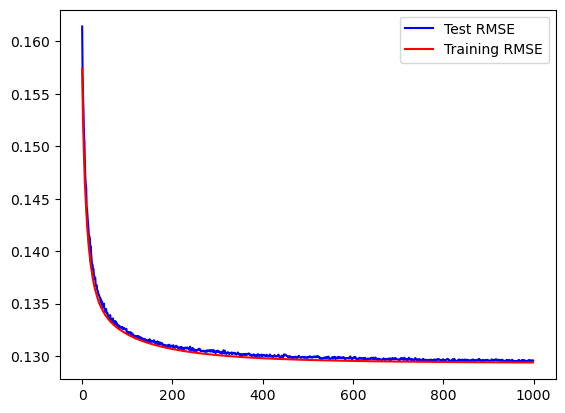

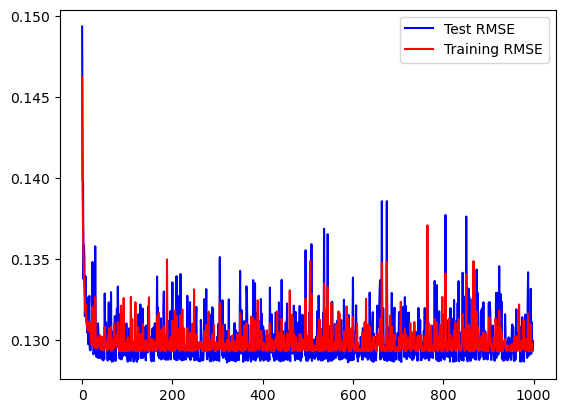

In [6]:
#Ordinary least squares
def ols_using_sgd(Xtrain, ytrain, Xtest, ytest, learning_rate, max_iter):

    regressor = SGDRegressor(penalty=None, learning_rate=learning_rate, shuffle=True)

    rmse_train = []
    rmse_test = []

    for epoch in range(max_iter):

        #fit the model for one epoch
        regressor.partial_fit(Xtrain, ytrain)

        #calculate rmse for model predictions on train and test data
        rmse_test.append(root_mean_squared_error(ytest, regressor.predict(Xtest)))
        rmse_train.append(root_mean_squared_error(ytrain, regressor.predict(Xtrain)))


    plt.plot(rmse_test, label="Test RMSE", color="blue")
    plt.plot(rmse_train, label="Training RMSE", color="red")
    plt.legend()

    plt.show()



#defining three sets of hyperparameters
learning_rate1 = 'constant'
learning_rate2 = 'invscaling'
learning_rate3 = 'adaptive'



ols_using_sgd(Xtrain_d2, ytrain_d2, Xtest_d2, ytest_d2, learning_rate1, 1000)
ols_using_sgd(Xtrain_d2, ytrain_d2, Xtest_d2, ytest_d2, learning_rate2, 1000)
ols_using_sgd(Xtrain_d2, ytrain_d2, Xtest_d2, ytest_d2, learning_rate3, 1000)


The Ordinary least squares model performs best with invscaling to compute the learning rate. Although the RMSE is relatively also low for the other two learning rates, fluctuations in the RMSE for both the training and test data suggests aggresive learning rates.

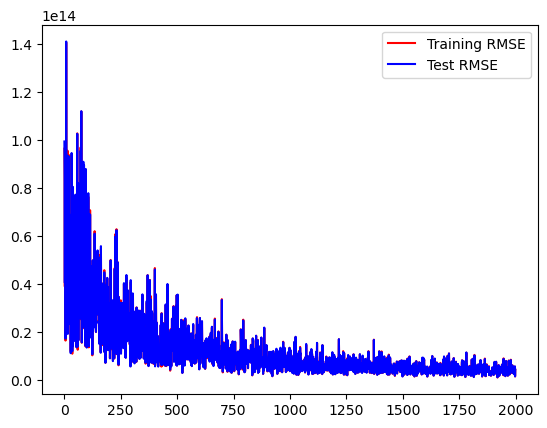

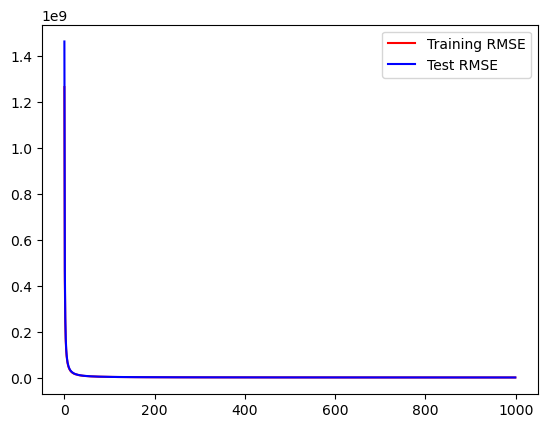

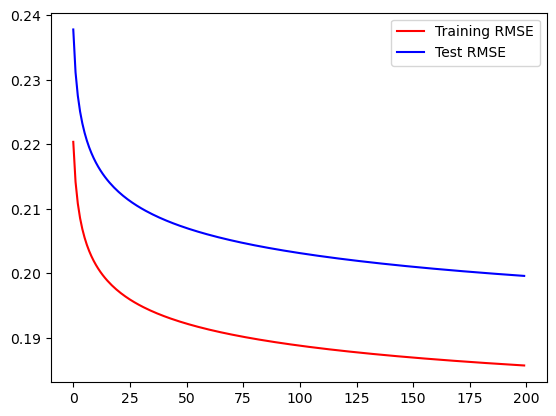

In [19]:
#Ridge regression

def ridge_reg_using_sgd(Xtrain, ytrain, Xtest, ytest, alpha, max_iter):
    regressor = SGDRegressor(penalty='l2', learning_rate='optimal', alpha=alpha, max_iter=max_iter, shuffle=True)
    rmse_train = []
    rmse_test = []

    for epoch in range(max_iter):
        regressor.partial_fit(Xtrain, ytrain)
        rmse_test.append(root_mean_squared_error(ytest, regressor.predict(Xtest)))
        rmse_train.append(root_mean_squared_error(ytrain, regressor.predict(Xtrain)))

    plt.plot(rmse_train, label="Training RMSE", color="red")
    plt.plot(rmse_test, label="Test RMSE", color="blue")
    plt.legend()

    plt.show()


#defining three sets of hyperparameters


alpha1 = 1e-7
alpha2 = 1e-2
alpha3 = 10

max_iter1 = 2000
max_iter2 = 1000
max_iter3 = 200

ridge_reg_using_sgd(Xtrain_d2, ytrain_d2, Xtest_d2, ytest_d2, alpha1, max_iter1)
ridge_reg_using_sgd(Xtrain_d2, ytrain_d2, Xtest_d2, ytest_d2, alpha2, max_iter2)
ridge_reg_using_sgd(Xtrain_d2, ytrain_d2, Xtest_d2, ytest_d2, alpha3, max_iter3)


A high regularization constant along with fewer number of epochs leads to a model the is underfitted. This is apparent in the third plot where the RMSE for both the training and test data are relatively high. A very low regularization constant is almost equivalent to there being no penalty on the weights that are learned.

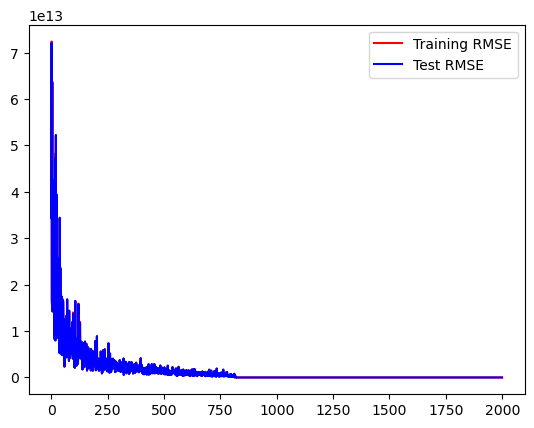

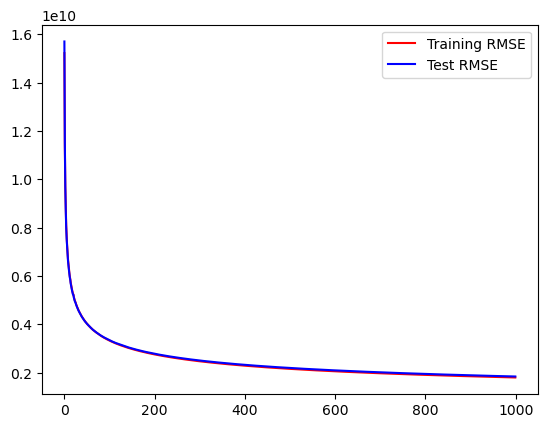

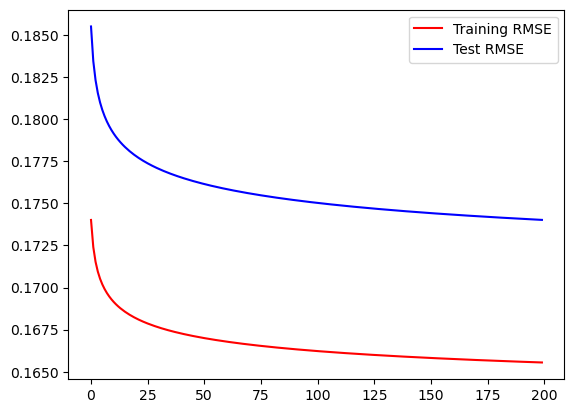

In [20]:
#Lasso

def lasso_using_sgd(Xtrain, ytrain, Xtest, ytest, alpha, max_iter):
    regressor = SGDRegressor(penalty='l1', learning_rate='optimal', alpha=alpha, max_iter=max_iter, shuffle=True)
    rmse_train = []
    rmse_test = []

    for epoch in range(max_iter):
        regressor.partial_fit(Xtrain, ytrain)
        rmse_test.append(root_mean_squared_error(ytest, regressor.predict(Xtest)))
        rmse_train.append(root_mean_squared_error(ytrain, regressor.predict(Xtrain)))

    plt.plot(rmse_train, label="Training RMSE", color="red")
    plt.plot(rmse_test, label="Test RMSE", color="blue")
    plt.legend()

    plt.show()


#defining three sets of hyperparameters

alpha1 = 1e-6
alpha2 = 1e-2
alpha3 = 10

max_iter1 = 2000
max_iter2 = 1000
max_iter3 = 200

lasso_using_sgd(Xtrain_d2, ytrain_d2, Xtest_d2, ytest_d2, alpha1, max_iter1)
lasso_using_sgd(Xtrain_d2, ytrain_d2, Xtest_d2, ytest_d2, alpha2, max_iter2)
lasso_using_sgd(Xtrain_d2, ytrain_d2, Xtest_d2, ytest_d2, alpha3, max_iter3)


Compared to Ridge regression where l2-norm penalty is used, lasso with l1-norm appears to be slightly better in fitting the data to the model. This might be due to variable selection capability that is inherent in models using l1-norm. However, for a larger regularization term the model still underfits the data.

All in all, adding a suitable regularization term penalises larger weights and allows the model to generalise well, preventing under- and overfitting.

Next, we tune Hyperparameters for each model using GridSearchCV

Best Ridge params: {'alpha': 1e-08, 'max_iter': 1500}
Best Lasso params: {'alpha': 0.0001, 'max_iter': 1500}


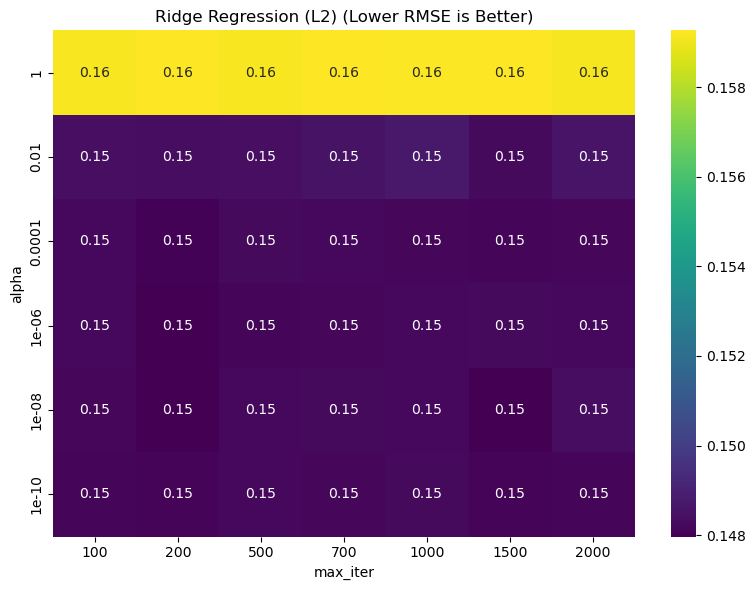

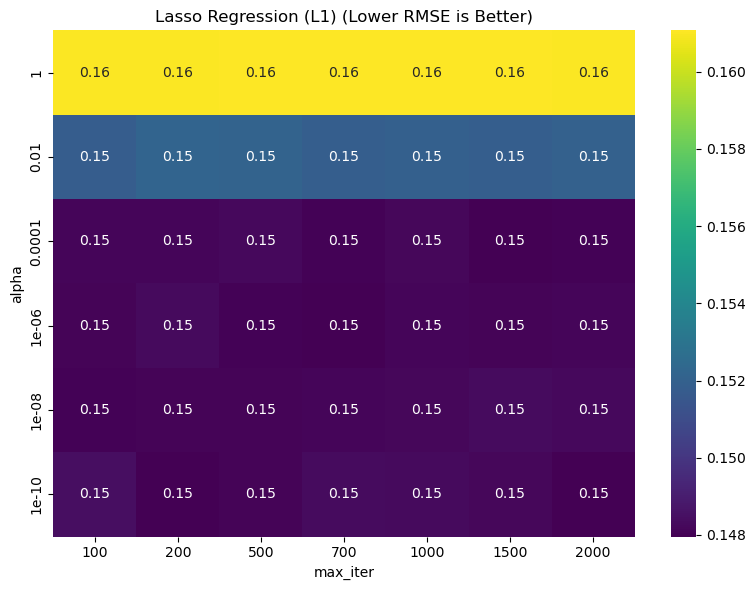

In [30]:
ridge_regressor = SGDRegressor(penalty='l2')
lasso = SGDRegressor(penalty='l1')

rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

params = {
    'alpha': [1, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10],
    'max_iter': [100, 200, 500, 700, 1000, 1500, 2000]
}


grid_ridge = GridSearchCV(ridge_regressor, param_grid=params, scoring=rmse_scorer, cv=5, n_jobs=-1)
grid_ridge.fit(Xtrain_d2, ytrain_d2)
best_ridge_params = grid_ridge.best_params_
print("Best Ridge params:", best_ridge_params)

grid_lasso = GridSearchCV(lasso, param_grid=params, scoring=rmse_scorer, cv=5, n_jobs=-1)
grid_lasso.fit(Xtrain_d2, ytrain_d2)
best_lasso_params = grid_lasso.best_params_
print("Best Lasso params:", best_lasso_params)


def plot_grid_search_results(grid, title):
    results = grid.cv_results_

    # Get unique values
    alphas = grid.param_grid['alpha']
    iters = grid.param_grid['max_iter']

    # Initialize score matrix
    scores = np.array(results['mean_test_score']).reshape(len(alphas), len(iters))

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(-scores, annot=True, xticklabels=iters, yticklabels=alphas, cmap="viridis")
    plt.xlabel("max_iter")
    plt.ylabel("alpha")
    plt.title(f"{title} (Lower RMSE is Better)")
    plt.tight_layout()
    plt.show()

# Plot Ridge results
plot_grid_search_results(grid_ridge, "Ridge Regression (L2)")

# Plot Lasso results
plot_grid_search_results(grid_lasso, "Lasso Regression (L1)")

The results from tuning hyperparameters using Gridsearch and CV strengthens the hypothesis that a balanced (not too small or large) regularization constant helps in learning a well generalizing model

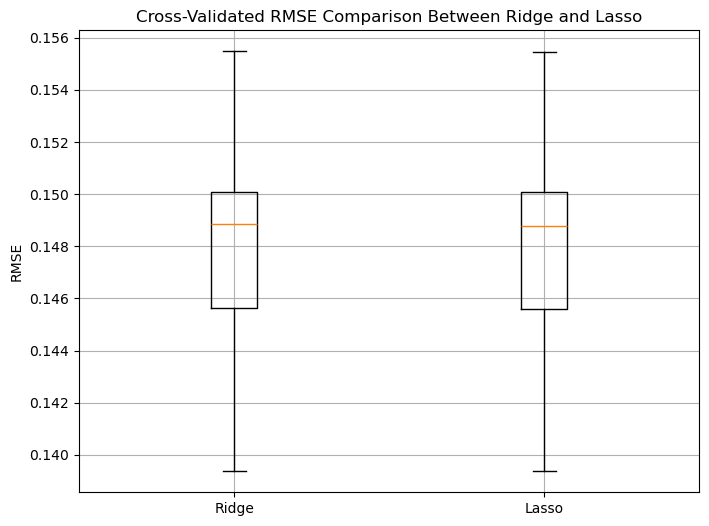

In [33]:
#Using the results from hyperparameter tuning to build the best model
best_ridge_model = SGDRegressor(penalty='l2', max_iter=best_ridge_params['max_iter'], tol=1e-3, random_state=42,
                         alpha=best_ridge_params['alpha'])
ridge_scores = cross_val_score(best_ridge_model, Xtrain_d2, ytrain_d2, cv=5, scoring=rmse_scorer, n_jobs=-1)



best_lasso_model = SGDRegressor(penalty='l1', max_iter=best_ridge_params['max_iter'], tol=1e-3, random_state=42,
                         alpha=best_lasso_params['alpha'])
lasso_scores = cross_val_score(best_lasso_model, Xtrain_d2, ytrain_d2, cv=5, scoring=rmse_scorer, n_jobs=-1)


#plot using boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([-ridge_scores, -lasso_scores], tick_labels=['Ridge', 'Lasso'])
plt.ylabel('RMSE')
plt.title('Cross-Validated RMSE Comparison Between Ridge and Lasso')
plt.grid(True)
plt.show()

The boxplots for Ridge and Lasso are nearly identical. This suggests that the choice between Ridge and Lasso doesn't significantly affect prediction performance on this dataset with current features and both models are able generalize similarly across the cross-validation folds

# Polynomial Regression

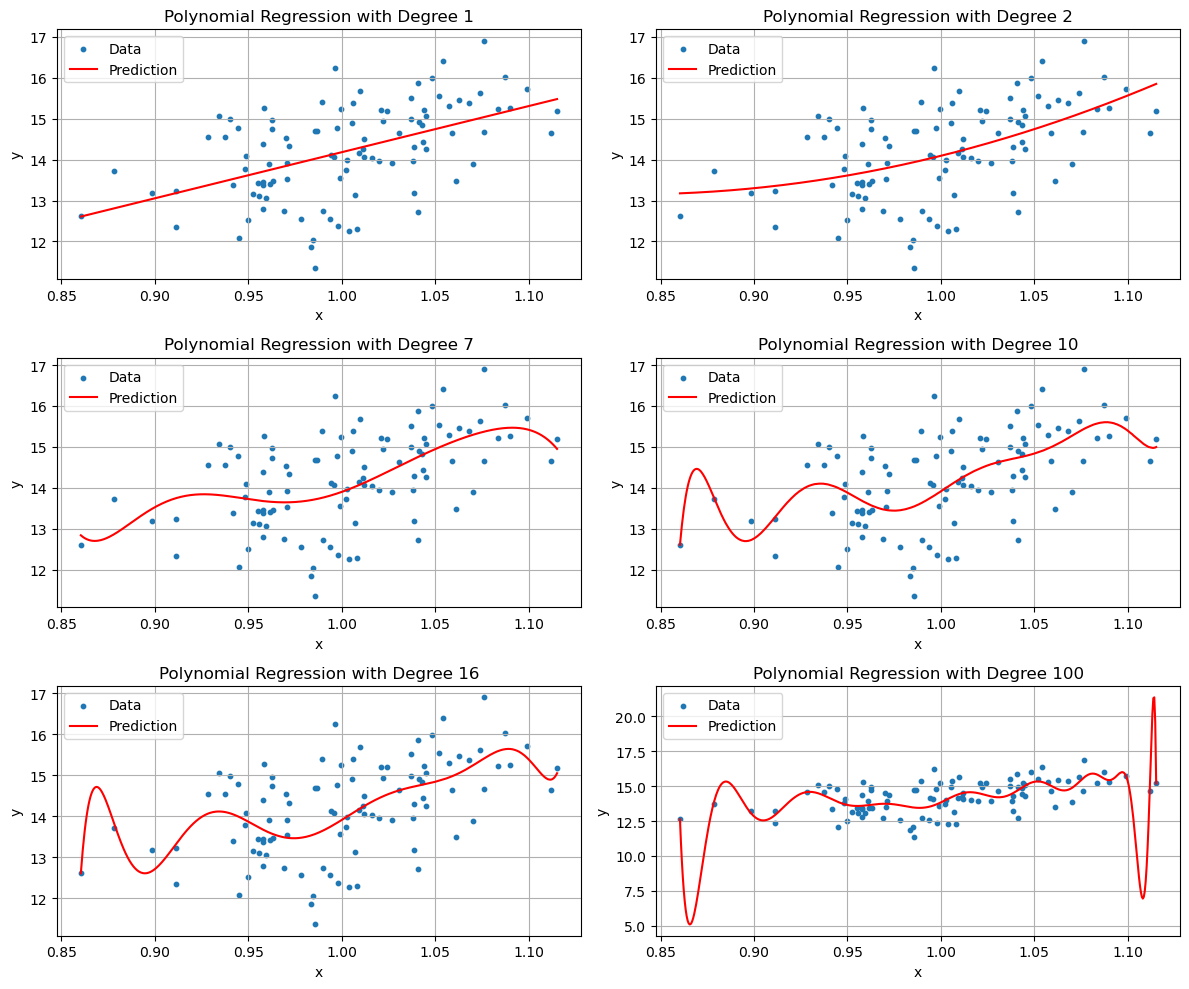

In [126]:
degrees = [1, 2, 7, 10, 16, 100]

#prediction grid to plot the curve
X_pred = np.linspace(X_d1.min(), X_d1.max(), 500).reshape(-1, 1)

plt.figure(figsize=(12, 10))

for i, degree in enumerate(degrees):

    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X_d1)

    #learn the model using the new dataset and y
    model = LinearRegression()
    model.fit(X_poly, y_d1)

    #transform the prediction input the same way as X_d1 and generate predictions using the previously fitted model
    X_pred_poly = poly.transform(X_pred)
    y_pred = model.predict(X_pred_poly)

    plt.subplot(3, 2, i + 1)
    #plotting original data
    plt.scatter(X_d1, y_d1, label="Data", s=10)
    #plotting polynomial features and predictions
    plt.plot(X_pred, y_pred, color='r', label="Prediction")
    plt.title(f"Polynomial Regression with Degree {degree}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()




As degree of the polynomial regression model increases, the model is able to memorize the data more. This leads to overfitting and poor generalization in the model. In the above plots, overfitting for models with higher degrees is especially noticeable at the edges of the dataset where the data points are scarcer.

Using regularization with fixed polynomial degree 10

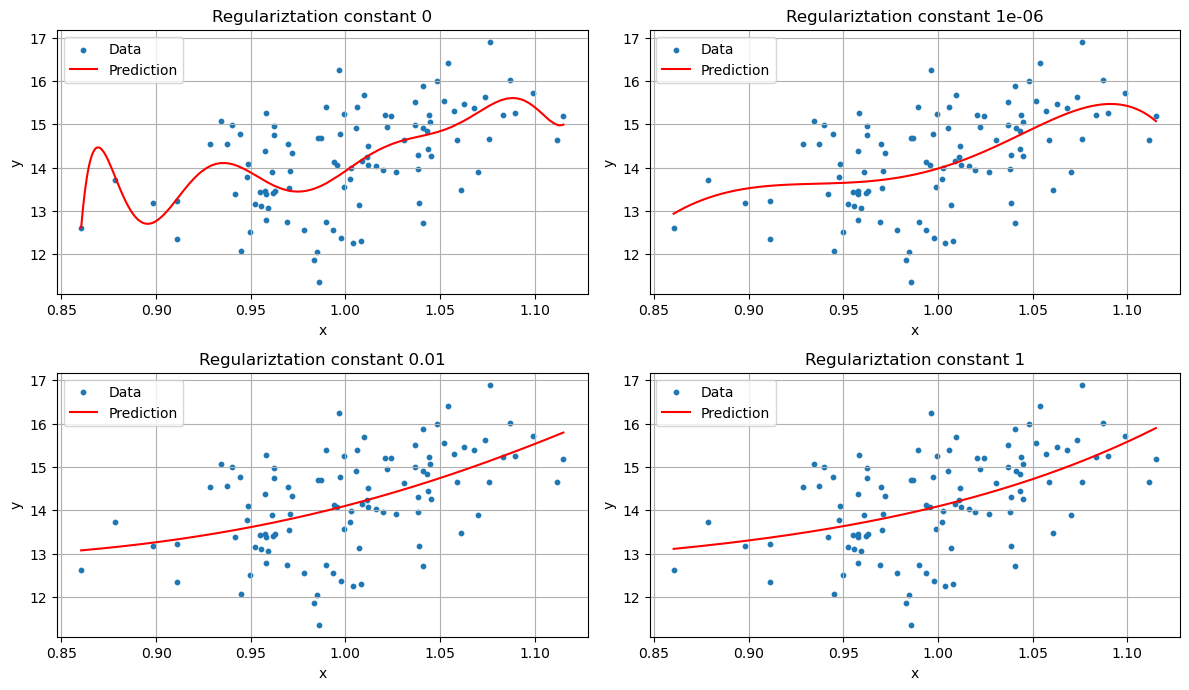

In [127]:
lamdas = [0, 1e-6, 1e-2, 1]
degree = 10

plt.figure(figsize=(12, 10))

for i, lamda in enumerate(lamdas):
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X_d1)

    #learn the model using the new dataset and y
    model = Ridge(alpha=lamda)
    model.fit(X_poly, y_d1)

    #transform the prediction input the same way as X_d1 and generate predictions using the previously fitted model
    X_pred_poly = poly.transform(X_pred)
    y_pred = model.predict(X_pred_poly)

    plt.subplot(3, 2, i + 1)
    #plotting original data
    plt.scatter(X_d1, y_d1, label="Data", s=10)
    #plotting polynomial features and predictions
    plt.plot(X_pred, y_pred, color='r', label="Prediction")
    plt.title(f"Regulariztation constant {lamda}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


Adding a regularization term to model penalizes larger weights and restricts the capacity of the model to memorize the data points, which in turn leads to model that generalizes well. In the example above, using a regularization constant of 0.01 delivers an optimal model.

# ELastic Net using SGD

In [35]:
#function to shuffle data
def shuffle_data(X, y):
    assert len(X) == len(y), "X and y must have the same number of samples"
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    return X[indices], y[indices]


def min_using_sgd(loss, gradient, Xtrain, ytrain, beta, learning_rate, t_max, tol):

    beta_values = [beta.copy()]



    for t in range(t_max):
        X_train_shuffled, y_train_shuffled = shuffle_data(Xtrain, ytrain)

        #calculate loss before update
        loss_before = loss(beta, X_train_shuffled, y_train_shuffled)

        #for each sample update parameter theta
        for i in range(len(X_train_shuffled)):

            #Calculate gradient at i-th sample
            g = gradient(beta, X_train_shuffled[i], y_train_shuffled[i])

            #choose learning rate with the adagrad heuristic
            #learning_rate, h_sum = adagrad_steplength(g, h_sum, mu_0=0.1)

            #update parameter
            beta -= learning_rate * g




        #loss after update
        loss_after = loss(beta, X_train_shuffled, y_train_shuffled)

        loss_change = abs(loss_after - loss_before)

        beta_values.append(beta.copy())


        if loss_change < tol:

            return beta_values

    print(f'No convergence in {t_max} epochs')
    return beta_values



def elastic_net_using_sgd(Xtrain, ytrain, reg_const_l1, reg_const_l2, learning_rate, i_max, tol):

    #Initial value for beta
    beta_0 = np.zeros(Xtrain.shape[1])

    #loss function
    def loss(beta, X, y):
        return (y - X @ beta).T @ (y - X @ beta) + reg_const_l2 * (beta.T @ beta) + reg_const_l1 * np.linalg.norm(beta, ord=1)


    #Gradient of loss function w.r.t. beta
    def gradient(beta, x, y):
        return 2 * (x @ beta - y) * x + (2 * reg_const_l2 * beta) + (reg_const_l1 * np.sign(beta))

    return min_using_sgd(loss, gradient, Xtrain, ytrain, beta_0, learning_rate, i_max, tol)


def calculate_rmse(beta, X, y):

    #predict target value using computed beta
    y_hat = X @ beta
    #find rmse compared to true target value
    rmse = np.sqrt(((y - y_hat) ** 2).mean())
    return rmse


In [36]:
learning_rate = 1e-4
eps = 5e-3
i_max = 1000

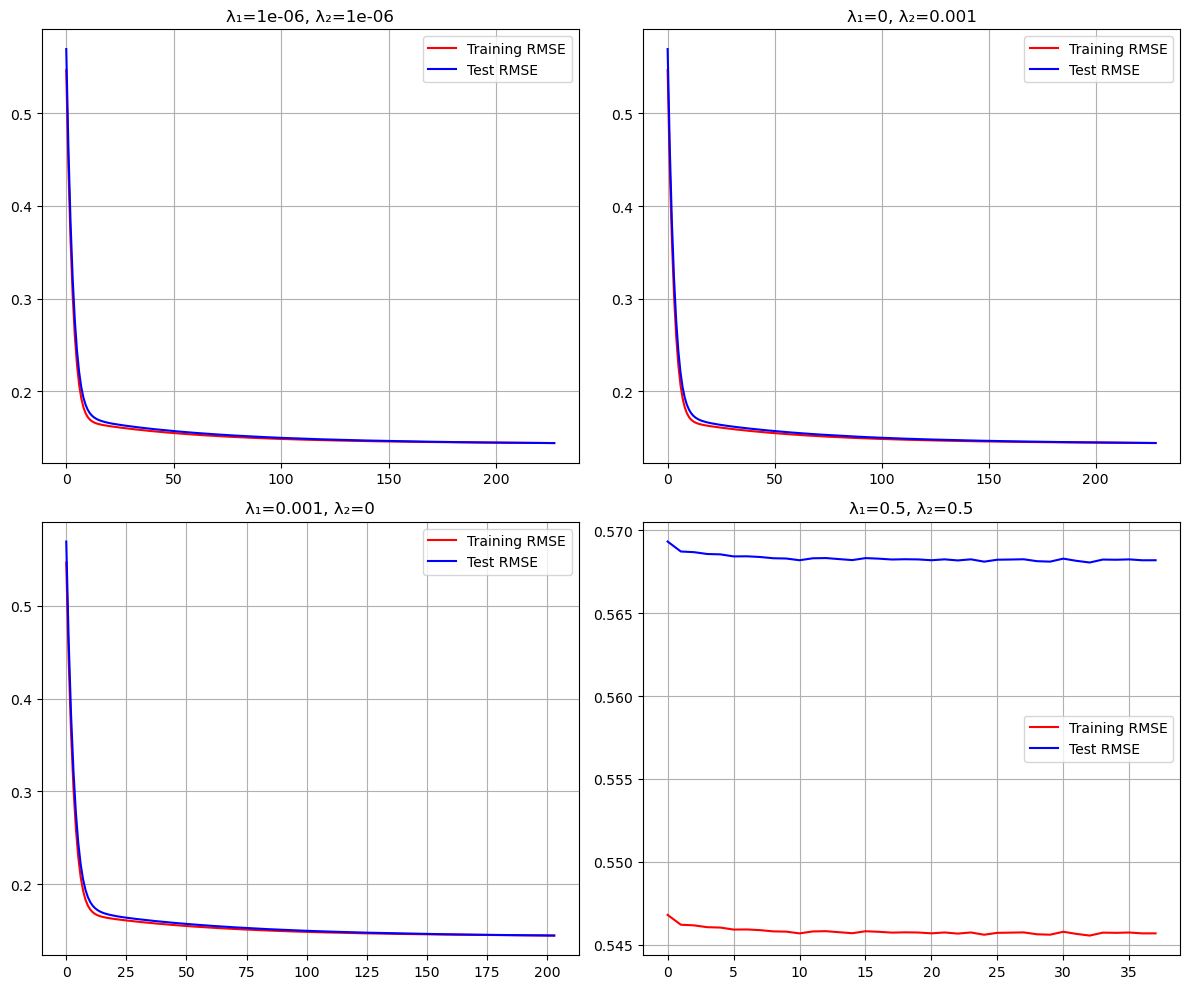

In [39]:
def learn_and_plot_subplot(ax, reg_const_l1, reg_const_l2):
    beta_values = elastic_net_using_sgd(Xtrain_d2, ytrain_d2, reg_const_l1, reg_const_l2, learning_rate, i_max, eps)

    RMSE_train = [calculate_rmse(beta, Xtrain_d2, ytrain_d2) for beta in beta_values]
    RMSE_test = [calculate_rmse(beta, Xtest_d2, ytest_d2) for beta in beta_values]

    ax.plot(RMSE_train, label="Training RMSE", color="red")
    ax.plot(RMSE_test, label="Test RMSE", color="blue")
    ax.set_title(f"λ₁={reg_const_l1}, λ₂={reg_const_l2}")
    ax.legend()
    ax.grid(True)

# Set up the 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

learn_and_plot_subplot(axes[0, 0], 1e-6, 1e-6)
learn_and_plot_subplot(axes[0, 1], 0, 1e-3)
learn_and_plot_subplot(axes[1, 0], 1e-3, 0)
learn_and_plot_subplot(axes[1, 1], 0.5, 0.5)

plt.tight_layout()
plt.show()

Choosing different combinations of regularization constants for the l2 and l1 penalty, we can see that the model behaves relatively well for all combinations apart from the combination where the constants are the largest. The plot suggests that the model is underfitting the data as larger weights are being penalized heavily.

Using Gridsearch and CV to fine-tune hyperparameters

In [40]:
#Function to split data into k folds. Returns a list of tuples containing split indices for training and validation
def k_fold_split (total_samples, k):


    indices = np.arange(total_samples)
    np.random.shuffle(indices)
    fold_sizes = np.full(k, total_samples // k)
    fold_sizes[:total_samples % k] += 1

    current = 0
    #array to hold training and validation indices of folds
    folds = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        val_idx = indices[start:stop]
        train_idx = np.concatenate((indices[:start], indices[stop:]))
        folds.append((train_idx, val_idx))
        current = stop
    return folds


def grid_search_elastic_net(X, y, lambda1_vals, lambda2_vals, k, i_max, eps):
    performance_grid = np.zeros((len(lambda1_vals), len(lambda2_vals)))
    folds = k_fold_split(len(X), k)

    for i, lambda1 in enumerate(lambda1_vals):
        for j, lambda2 in enumerate(lambda2_vals):
            val_errors = []

            for train_idx, val_idx in folds:
                X_train_fold, y_train_fold = X[train_idx], y[train_idx]
                X_val_fold, y_val_fold = X[val_idx], y[val_idx]

                beta_values = elastic_net_using_sgd(
                    X_train_fold, y_train_fold,
                    reg_const_l1=lambda1, reg_const_l2=lambda2,
                    learning_rate=1e-4,
                    i_max=i_max,
                    tol=eps
                )

                beta_final = beta_values[-1]
                val_error = calculate_rmse(beta_final, X_val_fold, y_val_fold)
                val_errors.append(val_error)

            performance_grid[i, j] = np.mean(val_errors)

    best_idx = np.unravel_index(np.argmin(performance_grid), performance_grid.shape)
    best_lambda1 = lambda1_vals[best_idx[0]]
    best_lambda2 = lambda2_vals[best_idx[1]]

    return best_lambda1, best_lambda2, performance_grid

In [41]:
X_wine = X = np.concatenate([Xtrain_d2, Xtest_d2], axis=0)
y_wine = np.concatenate([ytrain_d2, ytest_d2], axis=0)

lambda1_vals = [1e-2, 1e-3, 1e-4, 1e-6, 1e-7]
lambda2_vals = [1e-2, 1e-3, 1e-4, 1e-6, 1e-7]

best_l1, best_l2, perf_grid = grid_search_elastic_net(
    X_wine, y_wine,
    lambda1_vals, lambda2_vals,
    k=5, i_max=1000, eps=3e-3
)
print(f"Best λ₁: {best_l1}, Best λ₂: {best_l2}")

Best λ₁: 1e-06, Best λ₂: 1e-06
